#### Imports

In [7]:
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from plotting import plot_nan_percent

#### Config

In [8]:
K_LIST = [6, 12]

In [9]:
SPARSE_THRESHOLD = 0.95

#### Read data

In [10]:
DATA_PATH = Path("../data/")
df = pd.read_parquet(DATA_PATH / "dataset.parquet", engine="pyarrow")

In [11]:
print(list(df.columns))

['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID']


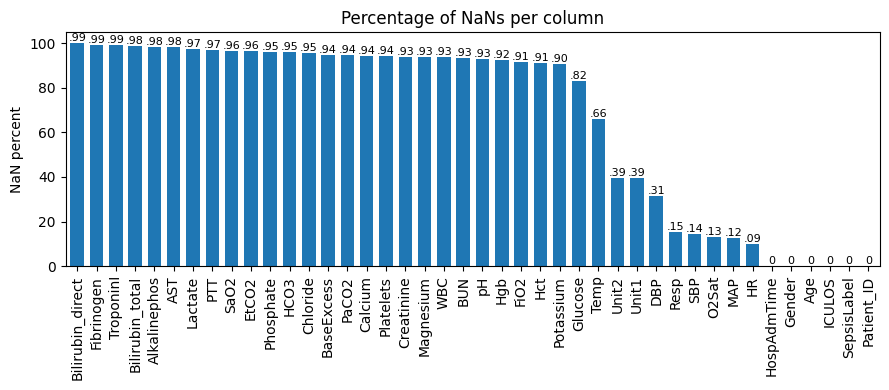

In [12]:
plot_nan_percent(df)

In [13]:
df = df.drop(columns=["Hour"], errors="ignore")

In [14]:
first_cols = ["Patient_ID", "Age", "Gender", "ICULOS", "SepsisLabel"]
other_cols = [c for c in df.columns if c not in first_cols]
df = df[first_cols + other_cols]

In [15]:
print(list(df.columns))

['Patient_ID', 'Age', 'Gender', 'ICULOS', 'SepsisLabel', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Unit1', 'Unit2', 'HospAdmTime']


#### Sort Data

In [16]:
df = df.sort_values(by=["Patient_ID", "ICULOS"]).reset_index(drop=True)

#### Columns

In [17]:
non_feature_cols = ["Patient_ID", "SepsisLabel"]
static_cols = ["Patient_ID", "Age", "Gender"]
binary_cols = ["Gender", "SepsisLabel"]

In [18]:
raw_dynamic_cols = [
    c for c in df.columns
    if c not in (non_feature_cols + static_cols + ["ICULOS"])
]


#### Filter

In [19]:
MIN_HOURS = 0
counts = df.groupby("Patient_ID").size()
valid_patients = counts[counts >= MIN_HOURS].index
df = df[df["Patient_ID"].isin(valid_patients)]

#### Log Transform

In [20]:
log_cols = [
    "Lactate", "Creatinine", "Bilirubin_total", "Bilirubin_direct",
    "AST", "Alkalinephos", "WBC", "Platelets",
    "Fibrinogen", "BUN", "Glucose", "Phosphate",
    "Magnesium", "Potassium",
]
log_cols = [col for col in log_cols if col in df.columns]

In [21]:
df[log_cols] = df[log_cols].clip(lower=0)
df[log_cols] = np.log1p(df[log_cols])

#### Missingness mask + Informative Missingness Features

##### 0/1 missingness mask (1 = missing at this hour BEFORE any imputation)

In [22]:
nan_mask_cols = [f"{col}_nan_mask" for col in raw_dynamic_cols]
df[nan_mask_cols] = df[raw_dynamic_cols].isna().astype(np.int8)

##### 1. Time since last measurement (hours)
* 0 if observed this hour
* positive integer if last observed earlier
* -1 if never observed so far in the stay

In [23]:
tslm_cols = [f"{col}_ts_last_meas" for col in raw_dynamic_cols]

In [24]:
out = {}
for col, out_col in zip(raw_dynamic_cols, tslm_cols):
    last_obs_iculos = (
        df["ICULOS"]
        .where(df[col].notna())
        .groupby(df["Patient_ID"])
        .ffill()
    )
    tslm = df["ICULOS"] - last_obs_iculos
    out[out_col] = tslm.where(last_obs_iculos.notna(), -1).astype(np.int16)

In [25]:
df = pd.concat([df, pd.DataFrame(out, index=df.index)], axis=1)

##### 2. Measurement frequency / count in last K hours (including current hour)

In [26]:
obs_ind = (~df[raw_dynamic_cols].isna()).astype(np.int8)

In [27]:
blocks = []
g = obs_ind[raw_dynamic_cols].groupby(df["Patient_ID"], sort=False)

for k in tqdm(K_LIST, desc="Rolling windows", dynamic_ncols=True):
    roll = (
        g.rolling(window=k, min_periods=1)
         .sum()
         .reset_index(level=0, drop=True)
         .astype(np.int16)
    )
    roll.columns = [f"{c}_meas_count_{k}h" for c in roll.columns]
    blocks.append(roll)

Rolling windows: 100%|██████████| 2/2 [01:13<00:00, 36.90s/it]


In [28]:
df = pd.concat([df, *blocks], axis=1, copy=False)
meas_count_cols = [c for c in df.columns if any(c.endswith(f"_meas_count_{k}h") for k in K_LIST)]

#### Group Split

In [1]:
TRAIN_PCT, VAL_PCT, TEST_PCT = 70, 20, 10
assert sum((TRAIN_PCT, VAL_PCT, TEST_PCT)) == 100

In [30]:
patients = df["Patient_ID"].unique()
patient_labels = df.groupby("Patient_ID")["SepsisLabel"].max()
labels_for_patients = patient_labels.loc[patients]

In [31]:
trainval_ids, test_ids = train_test_split(
    patients,
    test_size=TEST_PCT / 100,
    random_state=42,
    stratify=labels_for_patients,
)

In [32]:
labels_for_trainval = patient_labels.loc[trainval_ids]
train_ids, val_ids = train_test_split(
    trainval_ids,
    test_size=VAL_PCT / (TRAIN_PCT + VAL_PCT),
    random_state=42,
    stratify=labels_for_trainval,
)

In [33]:
for (name, split) in (("Train", train_ids), ("Validation", val_ids), ("Test", test_ids)):
    print(f"{name}: {len(split)} patients")
    labels = patient_labels.loc[split]
    num_pos = (labels == 1).sum()
    num_neg = (labels == 0).sum()
    print(f"  Negative patients: {num_neg}")
    print(f"  Positive patients: {num_pos}")
    print(f"  Ratio: {num_pos/num_neg:.3f}")
    print("")

Train: 28234 patients
  Negative patients: 26182
  Positive patients: 2052
  Ratio: 0.078

Validation: 8068 patients
  Negative patients: 7481
  Positive patients: 587
  Ratio: 0.078

Test: 4034 patients
  Negative patients: 3741
  Positive patients: 293
  Ratio: 0.078



In [34]:
train_df = df[df["Patient_ID"].isin(train_ids)].copy()
val_df = df[df["Patient_ID"].isin(val_ids)].copy()
test_df = df[df["Patient_ID"].isin(test_ids)].copy()

#### Identify Extremely Sparse Variables and Remove Their Numeric Channels

In [35]:
train_obs_rate = 1.0 - train_df[nan_mask_cols].mean()
train_missing_ratio_pre = 1.0 - train_obs_rate
train_missing_ratio_pre.index = raw_dynamic_cols

In [36]:
raw_dynamic_sparse_cols = train_missing_ratio_pre[train_missing_ratio_pre > SPARSE_THRESHOLD].index.tolist()
raw_dynamic_dense_cols = [c for c in raw_dynamic_cols if c not in raw_dynamic_sparse_cols]

In [37]:
print("Sparse columns:", raw_dynamic_sparse_cols)
print("Dense dynamic cols:", len(raw_dynamic_dense_cols))
print("Sparse dynamic cols:", len(raw_dynamic_sparse_cols))

Sparse columns: ['EtCO2', 'HCO3', 'SaO2', 'AST', 'Alkalinephos', 'Chloride', 'Bilirubin_direct', 'Lactate', 'Phosphate', 'Bilirubin_total', 'TroponinI', 'PTT', 'Fibrinogen']
Dense dynamic cols: 24
Sparse dynamic cols: 13


In [38]:
for col in raw_dynamic_sparse_cols:
    train_df[col] = np.nan
    val_df[col] = np.nan
    test_df[col] = np.nan

#### Imputation

##### 1. Forward-Fill (only dense numeric channels)

In [39]:
train_df[raw_dynamic_dense_cols] = train_df.groupby("Patient_ID")[raw_dynamic_dense_cols].ffill()
val_df[raw_dynamic_dense_cols] = val_df.groupby("Patient_ID")[raw_dynamic_dense_cols].ffill()
test_df[raw_dynamic_dense_cols] = test_df.groupby("Patient_ID")[raw_dynamic_dense_cols].ffill()

In [40]:
def add_rolling_features(df_split: pd.DataFrame, cols: list[str], k_list=(6, 12)) -> pd.DataFrame:
    """
    Trailing (past k hours, incl. current) rolling features per patient.
    Assumes df_split is already sorted by [Patient_ID, ICULOS].
    """
    blocks = []

    g = df_split[cols].groupby(df_split["Patient_ID"], sort=False)

    for k in tqdm(k_list, desc="Rolling windows", total=len(k_list)):
        r = g.rolling(window=k, min_periods=1)

        mean = r.mean().reset_index(level=0, drop=True)
        mn   = r.min().reset_index(level=0, drop=True)
        mx   = r.max().reset_index(level=0, drop=True)
        std  = r.std(ddof=0).reset_index(level=0, drop=True)

        mean.columns = [f"{c}_roll_mean_{k}h" for c in cols]
        mn.columns   = [f"{c}_roll_min_{k}h"  for c in cols]
        mx.columns   = [f"{c}_roll_max_{k}h"  for c in cols]
        std.columns  = [f"{c}_roll_std_{k}h"  for c in cols]

        q25 = r.quantile(0.25).reset_index(level=0, drop=True)
        q50 = r.quantile(0.50).reset_index(level=0, drop=True)
        q75 = r.quantile(0.75).reset_index(level=0, drop=True)

        q25.columns = [f"{c}_roll_q25_{k}h" for c in cols]
        q50.columns = [f"{c}_roll_med_{k}h" for c in cols]
        q75.columns = [f"{c}_roll_q75_{k}h" for c in cols]

        iqr = (q75.values - q25.values)
        iqr = pd.DataFrame(iqr, index=df_split.index, columns=[f"{c}_roll_iqr_{k}h" for c in cols])

        block = pd.concat([mean, std, mn, mx, q50, iqr], axis=1).astype(np.float32, copy=False)
        blocks.append(block)

    return pd.concat(blocks, axis=1)

In [41]:
train_roll = add_rolling_features(train_df, raw_dynamic_dense_cols, K_LIST)
val_roll = add_rolling_features(val_df, raw_dynamic_dense_cols, K_LIST)
test_roll = add_rolling_features(test_df, raw_dynamic_dense_cols, K_LIST)

train_df = pd.concat([train_df, train_roll], axis=1, copy=False)
val_df = pd.concat([val_df, val_roll], axis=1, copy=False)
test_df = pd.concat([test_df, test_roll], axis=1, copy=False)

Rolling windows: 100%|██████████| 2/2 [00:39<00:00, 19.74s/it]


#### Neutral fill for leading NaNs (pre-first-measurement) using train statistics only

In [42]:
rolling_cols = train_roll.columns.tolist()

In [43]:
cols_to_fill = raw_dynamic_dense_cols + rolling_cols

In [44]:
fill_values = {}
for col in raw_dynamic_dense_cols:
    mask_col = f"{col}_nan_mask"
    observed = train_df[col].where(train_df[mask_col] == 0)

    v = observed.median()
    if pd.isna(v):
        v = 0.0
    fill_values[col] = float(v)

In [45]:
for col in rolling_cols:
    v = train_df[col].median()
    if pd.isna(v):
        v = 0.0
    fill_values[col] = float(v)

In [46]:
train_df[cols_to_fill] = train_df[cols_to_fill].fillna(fill_values)
val_df[cols_to_fill] = val_df[cols_to_fill].fillna(fill_values)
test_df[cols_to_fill] = test_df[cols_to_fill].fillna(fill_values)

#### Saving

In [47]:
splits_path = DATA_PATH / "splits"
splits_path.mkdir(parents=True, exist_ok=True)

In [48]:
train_df.to_parquet(splits_path / "train.parquet", engine="pyarrow", index=False)
val_df.to_parquet(splits_path / "val.parquet", engine="pyarrow", index=False)
test_df.to_parquet(splits_path / "test.parquet", engine="pyarrow", index=False)

In [49]:
joblib.dump(
    {
        "fill_values": fill_values,
        "fill_stat": "median",
        "raw_dynamic_cols": raw_dynamic_cols,
        "raw_dynamic_dense_cols": raw_dynamic_dense_cols,
        "raw_dynamic_sparse_cols": raw_dynamic_sparse_cols,
        "nan_mask_cols": nan_mask_cols,
        "tslm_cols": tslm_cols,
        "meas_count_cols": meas_count_cols,
        "sparse_threshold": SPARSE_THRESHOLD,
    },
    DATA_PATH / "preprocess_artifacts.pkl",
)

['..\\data2\\preprocess_artifacts.pkl']